# Обучение с учителем: качество модели

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. 

Предстоит разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.


## Загрузка данных

Начнем с импорта всех необходимых библиотек. 

In [1]:
!pip install shap

     |████████████████████████████████| 532 kB 1.1 MB/s eta 0:00:01


In [2]:
pip install phik

     |████████████████████████████████| 679 kB 1.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install -U scikit-learn

     |████████████████████████████████| 10.9 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 302 kB 81.6 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification

import shap

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

<div style="border:solid purple 5px; padding: 20px">
<h2 align="center"> Рубрика «Питонячий лайфхакер» <a class="tocSkip"> </h2>
    
<h3> Широкоформатный Jupyter <a class="tocSkip"> </h3>
    
Расширяем границы, или как сделать работу более комфортной (не всем нравится 😄)

    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:90% !important; }</style>"))
    
     🔥 😉


Загрузим данные.

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

In [5]:
market_file = pd.read_csv('/datasets/market_file.csv', sep=',', decimal='.')
display(market_file.sample(10))
print(market_file.info())
display(market_file.describe())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
1030,216378,Прежний уровень,премиум,да,5.7,3,636,0.14,Товары для детей,3,2,7,11
238,215586,Снизилась,премиум,да,4.1,4,557,0.94,Техника для красоты и здоровья,1,8,3,3
773,216121,Прежний уровень,стандарт,да,5.0,5,334,0.14,Домашний текстиль,3,3,4,14
1263,216611,Прежний уровень,стандарт,да,3.9,4,515,0.13,Мелкая бытовая техника и электроника,3,0,2,10
252,215600,Снизилась,стандарт,да,2.4,4,446,0.29,Кухонная посуда,1,6,3,4
1046,216394,Прежний уровень,стандарт,нет,4.7,3,440,0.12,Мелкая бытовая техника и электроника,4,2,4,10
840,216188,Прежний уровень,стандарт,нет,2.6,4,161,0.13,Домашний текстиль,5,4,4,8
57,215405,Снизилась,стандарт,да,3.0,3,669,0.34,Кухонная посуда,4,2,5,4
966,216314,Прежний уровень,премиум,да,5.5,5,269,0.21,Товары для детей,2,4,1,17
917,216265,Прежний уровень,стандарт,да,4.2,3,846,0.30,Домашний текстиль,3,4,4,9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>

👍, всегда нужно проверять корректность загрузки данных

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

In [6]:
market_money = pd.read_csv('/datasets/market_money.csv', sep=',', decimal='.')
display(market_money.sample(10))
print(market_money.info())
display(market_money.describe())

,id,Период,Выручка
1988,216010,предыдущий_месяц,4719.0
144,215396,препредыдущий_месяц,4805.0
2646,216230,предыдущий_месяц,5246.0
2485,216176,текущий_месяц,2952.2
538,215527,предыдущий_месяц,3229.0
2344,216129,текущий_месяц,4091.4
3307,216450,текущий_месяц,5521.0
3258,216434,текущий_месяц,5258.0
1684,215909,текущий_месяц,4687.1
2114,216052,предыдущий_месяц,5898.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None


,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

In [7]:
market_time = pd.read_csv('/datasets/market_time.csv', sep=',', decimal='.')
display(market_time.sample(10))
print(market_time.info())
display(market_time.describe())

,id,Период,минут
594,215645,предыдцщий_месяц,10
321,215508,текущий_месяц,5
2525,216610,предыдцщий_месяц,12
293,215494,текущий_месяц,13
1395,216045,текущий_месяц,11
1057,215876,текущий_месяц,14
1881,216288,текущий_месяц,16
2319,216507,текущий_месяц,15
1743,216219,текущий_месяц,20
1926,216311,текущий_месяц,9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

In [8]:
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
display(money.sample(10))
print(money.info())
display(money.describe())

,id,Прибыль
788,216136,4.38
166,215514,5.00
82,215430,4.63
532,215880,4.23
680,216028,4.09
98,215446,4.52
387,215735,2.90
204,215552,4.33
673,216021,3.67
495,215843,4.68


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None


,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>

Отличная загрузка! Сразу исправляет ошибки в столбцах

Приведем данные в столбце прибыль в тысячи рублей, как в других таблицах.

In [9]:
money['Прибыль'] = money['Прибыль']*1000

<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>

В ТЗ, кстати, про это явно не говорится, ну да ладно)

Пропусков в таблицах нет. Типы данных определны верно. Данные в таблицах соответствуют описанию.

<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>

Здесь все хорошо, можно идти дальше

## Предобработка данных

Проверим наличие явных дубликатов среди строк таблицы, чтобы исключить их и исключить влияние таких выбросов на модель классификации.

In [10]:
print('Найдено явных дубликатов:', market_file.duplicated().sum())

Найдено явных дубликатов: 0


In [11]:
print('Найдено явных дубликатов:', market_money.duplicated().sum())

Найдено явных дубликатов: 0


In [12]:
print('Найдено явных дубликатов:', market_time.duplicated().sum())

Найдено явных дубликатов: 0


In [13]:
print('Найдено явных дубликатов:', money.duplicated().sum())

Найдено явных дубликатов: 0


<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>

Да, полных дубликатов нет, но я бы посмотрел по `id` все ли записи уникальные и относятся к разным пользователям, или есть какие-то артефакты...

Полных дубликатовне не выявлено

In [14]:
len(market_file['id'].unique())

1300

Количество уникальных id соответствует количеству строк. Дубликатов id тоже не выявлено.

Проведем необходимую предобработку данных. Проверим уникальные значения категориальных признаков.

In [15]:
print(market_file["Покупательская активность"].unique())
print(market_file["Тип сервиса"].unique())
print(market_file["Разрешить сообщать"].unique())
print(market_file["Популярная_категория"].unique())

['Снизилась' 'Прежний уровень']
['премиум' 'стандартт' 'стандарт']
['да' 'нет']
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


Проведем замену в столбце Тип сервиса 

In [16]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace('стандартт', 'стандарт' )

In [17]:
market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

В этой таблице замены не требуются. Проверим последнюю таблицу и проведем замену в столбце Период.

In [18]:
market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [19]:
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц' )

<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>

Огонь, идем хорошо)

## Исследовательский анализ данных

Проведем статистический анализ всех признаков. Выведем описательные статистики для всех признаков.

In [20]:
market_file.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [21]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [22]:
float_col_names = ['Маркет_актив_6_мес', 
                 'Акционные_покупки',
                  'Длительность']

int_col_names = ['Маркет_актив_тек_мес',
                 'Средний_просмотр_категорий_за_визит',
                 'Страниц_за_визит',
                 'Неоплаченные_продукты_штук_квартал', 
                 'Ошибка_сервиса']

cat_col_names = ['Покупательская активность', 
                 'Тип сервиса',
                 'Разрешить сообщать',
                 'Популярная_категория']

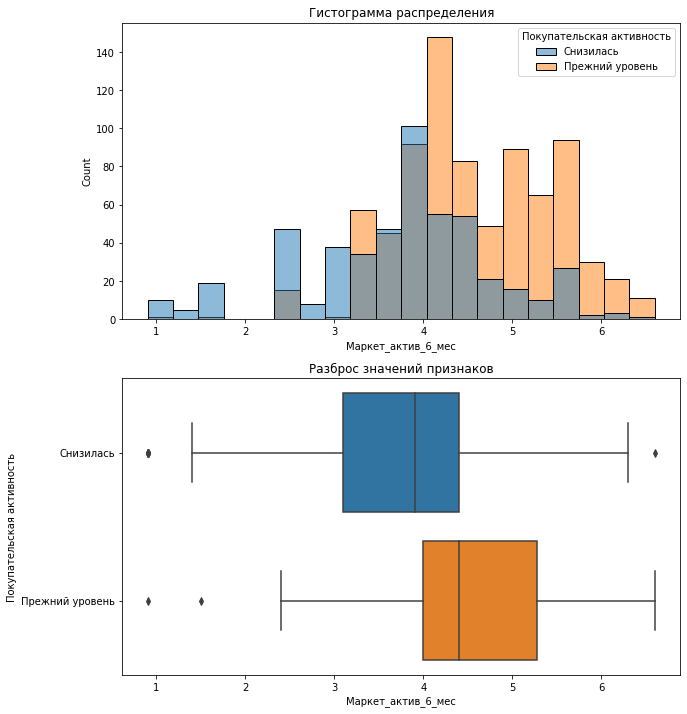

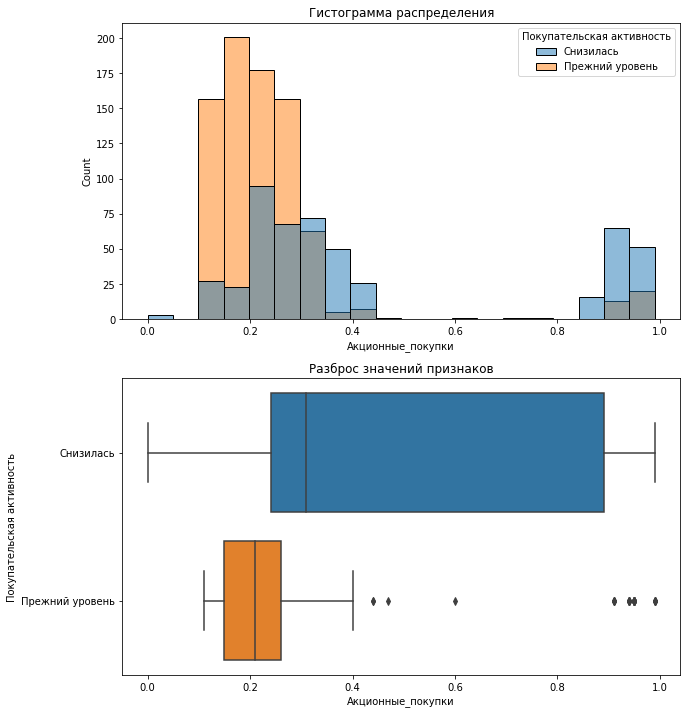

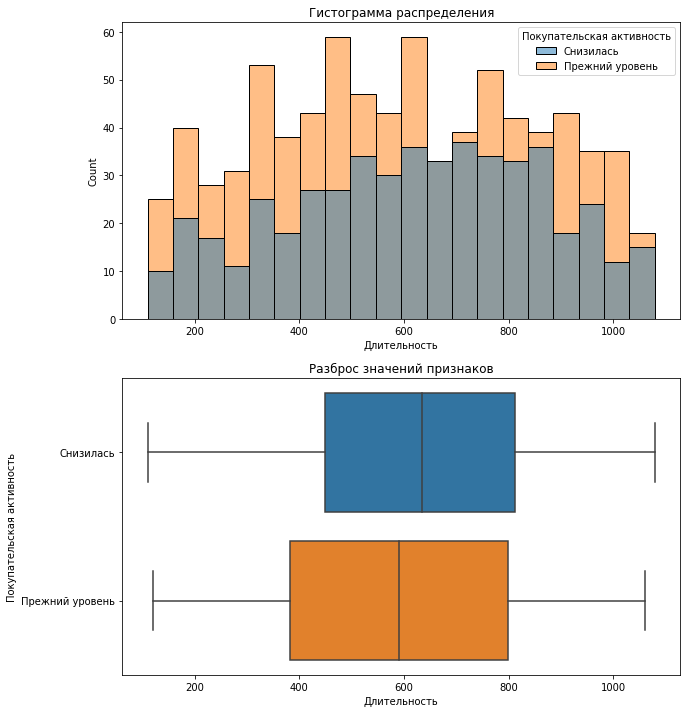

In [23]:
for name in float_col_names:
    fig, axes = plt.subplots(2, 1, figsize=(10,12))
    sns.histplot(x=name, hue='Покупательская активность', data = market_file, bins=20, alpha=0.5, ax=axes[0])
    #market_file.plot(kind='hist', bins=10, y=name, figsize=(10,12), grid = True, alpha=0.5, ax=axes[0])
    axes[0].set_title('Гистограмма распределения')
    #market_file.plot(kind='box', y=name, x='Покупательская активность', ax=axes[1], grid = True, rot=90, vert=False)
    sns.boxplot(data=market_file, x=name, y='Покупательская активность', ax=axes[1])
    axes[1].set_title('Разброс значений признаков')

По полученным графикам можно сделать следующие выводы: 

- при большем значении маркетинговых коммуникаций компании (рассылок, звонков, показов рекламы и прочего) за последние полгода покупательская активность чаще сохранялась на прежнем уровне. При маркетинговой активности ниже 3х коммунакаций - покупательская активность снижалась;

- покупательская активность показала зависимость от доли покупок по акции от общего числа покупок за последние 6 месяцев. Выявлена четкая граница - 30%. Если доля акционных покупок составляла ниже 30% покупательская активность значитально снижалась;

- длительноть времени с момента регистрации покупателя на сайте не влияет на покупательную активность. 

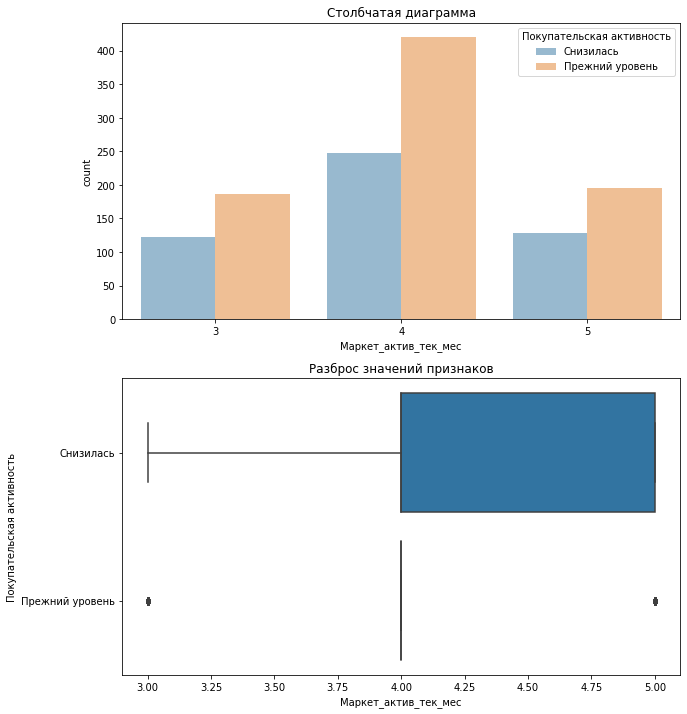

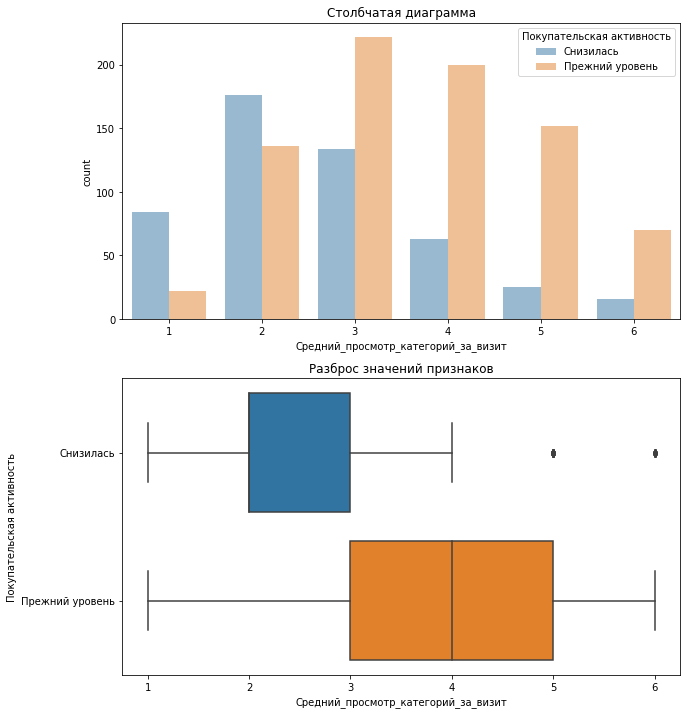

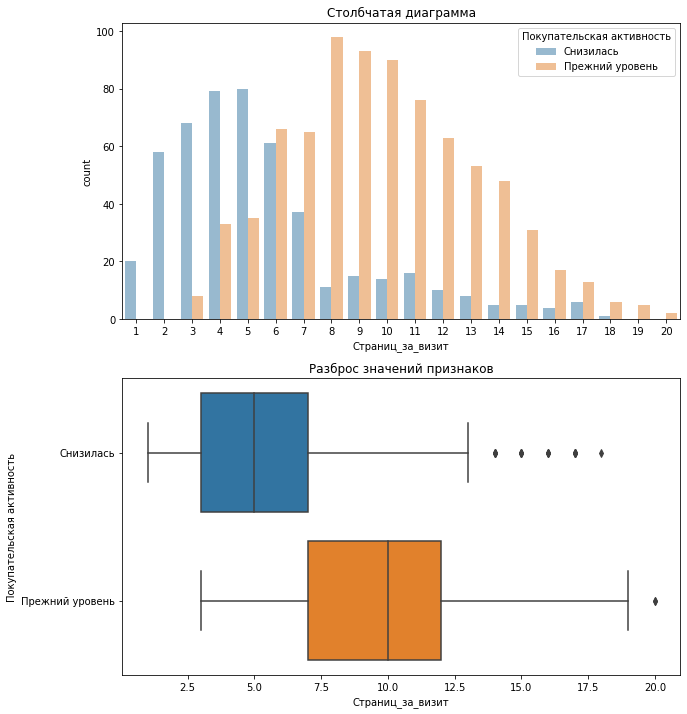

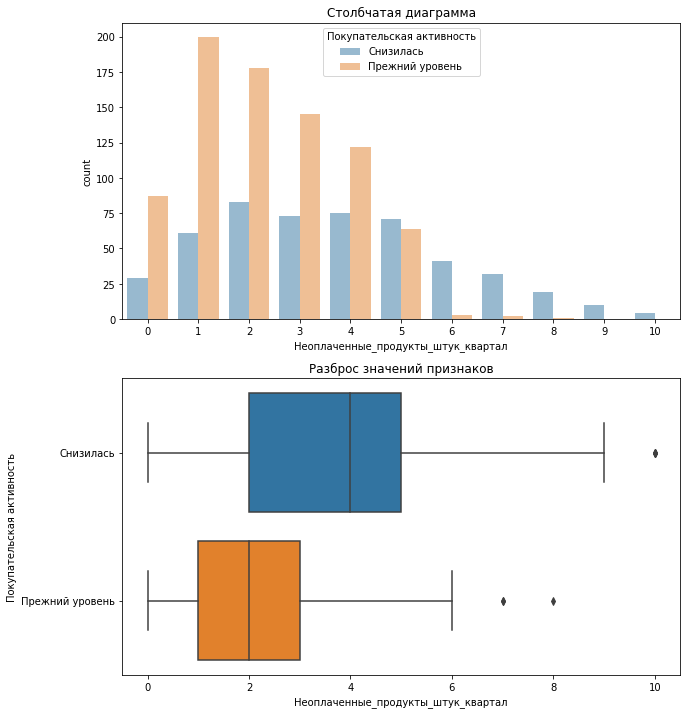

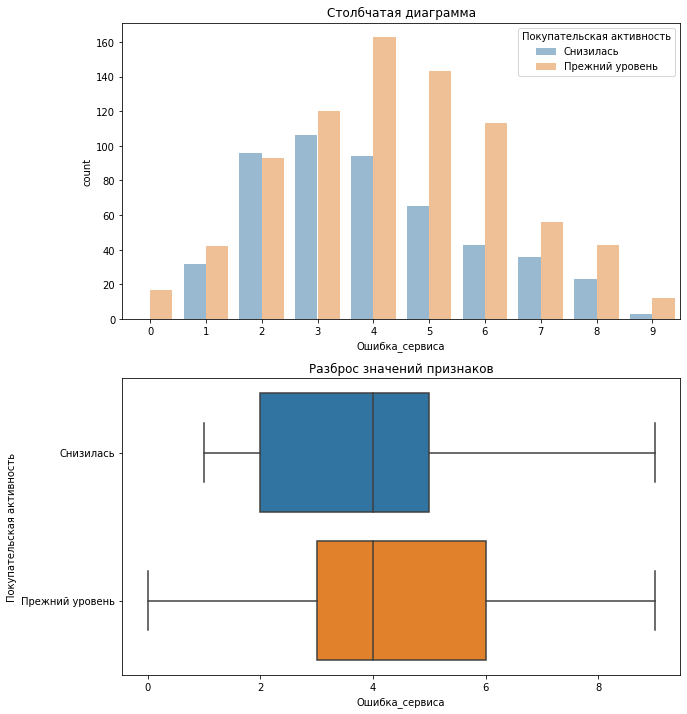

In [24]:
for name in int_col_names:
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))
    sns.countplot(x = name, hue = 'Покупательская активность', data = market_file,  alpha=0.5, ax=axes[0]);
    axes[0].set_title('Столбчатая диаграмма')
    #market_file.plot(kind='box', y=name, grid = True, rot=90, vert=False, ax=axes[1])
    sns.boxplot(data=market_file, x=name, y='Покупательская активность', ax=axes[1])
    axes[1].set_title('Разброс значений признаков')

<div class="alert alert-success">
<h2> Комментарий ревьюера v2 ✔️ <a class="tocSkip"> </h2>

Классно, только я боксплоты тоже бы делил по таргету

Выводы:

- при маркетинговой активности от 3х коммунакаций - покупательская активность в большем % соотношении остается на прежднем уровне, т.е. маркетинговая активность стимулирует  активность покупателей;

-  при большем количестве просмотренных категорий за визит покупатель с большей вероятностью совершит покупку;

-  чем выше среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца, тем выше покупательская активность;

- постоянные покутели часто "хранят" в корзине до 5 неоплаченных товаров, а те покупатели, активность которых снизилась, могут держать в корзине до 10 товаров, но все-таки значительно реже неоплачивают отобранные товары;

- число сбоев, которые коснулись покупателя во время посещения сайта, не влияет на покупательскую активность.

In [25]:
#for name in int_col_names:
#    fig, axes = plt.subplots(nrows=2, ncols=1)
#    market_file.value_counts(name).plot.bar(y=name, figsize=(10,12), grid = True, alpha=0.5, ax=axes[0])
#    axes[0].set_title('Столбчатая диаграмма')
#    market_file.plot(kind='box', y=name, figsize=(10,12), ax=axes[1], grid = True, rot=90, vert=False)
#    axes[1].set_title('Разброс значений признаков')
 #   plt.show()

<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>

Эти два графика я бы расположил друг под другом, при этом удачное решение расположить боксплот горизонтально, тогда графики будут друг под другом, и у них как бы будет единая ось икс
    
</div>

<div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️ <a class="tocSkip"> </h2>

Все столбцы с типом данных `int` я бы отрисовал в виде баров, гистограмма для них не совсем подолдит

<div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️ <a class="tocSkip"> </h2>

Раз проект нацелен на бинарный целевой признак, советую проводить анализ с разделением по целевому графику, т.е на одном графике строить две гистограммы с разбивкой по столбцу `Покупательская активность`.

Построим графики, которые описывают категориальные признаки.

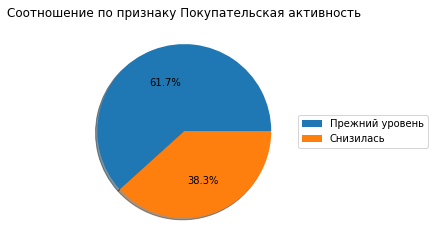

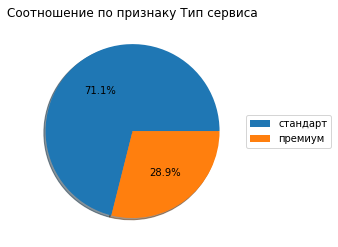

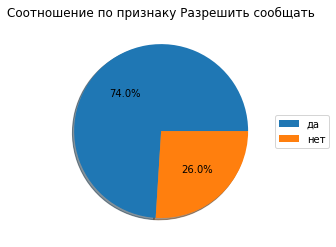

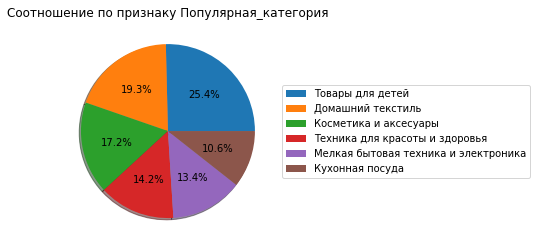

In [26]:
for name in cat_col_names:
    market_file[name].value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, 
                legend=True, title=f'Соотношение по признаку {name}', ylabel='', labeldistance=None)
    plt.legend(bbox_to_anchor=(1, 0, 0.5, 1), loc="center left")
    plt.show()  

Бинарные категориальные данные распредлены в пропорции 1 к 3. Все товары распределены на 6 категорий где наибольшая доля - 25% - Тоавры для детей, минимальная доля приходится на Кухонную утварь  - 10%.

In [27]:
market_money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


Максимальное значение выбивается. Рассмотрим данные 4го квартиля + std.

In [28]:
market_money[market_money['Выручка']>(5363+1777.704104)].sort_values(by='Выручка')

,id,Период,Выручка
306,215450,текущий_месяц,7160.0
843,215629,текущий_месяц,7160.9
1392,215812,текущий_месяц,7167.4
2205,216083,текущий_месяц,7182.2
1247,215763,текущий_месяц,7208.8
631,215558,текущий_месяц,7212.3
1925,215989,текущий_месяц,7310.0
2621,216221,текущий_месяц,7314.0
1250,215764,текущий_месяц,7325.4
1770,215938,текущий_месяц,7338.2


Данные 98 строки  - явный выброс. Заменим на медианное значение. 

In [29]:
market_money['Выручка'].loc[market_money['Выручка']>100000] = market_money['Выручка'].median()

In [30]:
market_money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,4999.566641
std,375.325686,706.909531
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.250000
75%,216322.250000,5363.000000
max,216647.000000,7799.400000


<div class="alert alert-danger">
<h2> Комментарий ревьюера ❌ <a class="tocSkip"> </h2>

Привязываться к индексам не очень хорошая практика, в случае, если данные как-то поменяются, или добавятся новые строки, это решение не будет корректным. Предлагаю считать выбросом все, что больше 100_000

<div class="alert alert-success">
<h2> Комментарий ревьюера v2 ✔️ <a class="tocSkip"> </h2>

👍

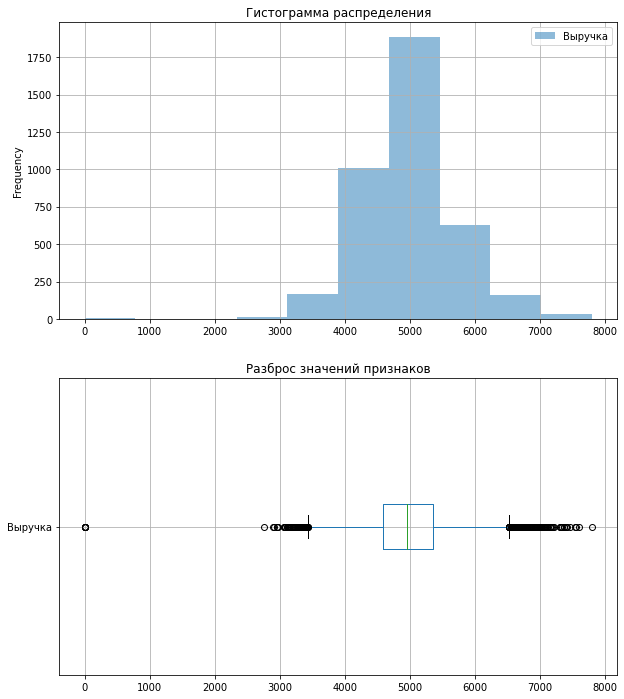

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(10, 12))
market_money.plot(kind='hist', bins=10, y='Выручка', grid = True, alpha=0.5, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
market_money.plot(kind='box', y='Выручка', ax=axes[1], vert=False, grid = True)
axes[1].set_title('Разброс значений признаков')
plt.show()

In [32]:
f'Количество строк с 0 выручкой в датасете: {market_money["Выручка"].loc[market_money["Выручка"]==0].count()}'

'Количество строк с 0 выручкой в датасете: 6'

In [33]:
market_time.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


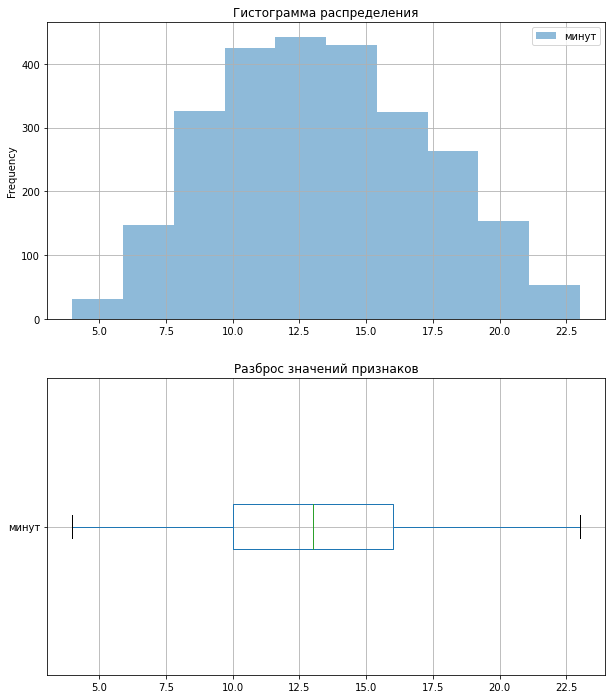

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(10, 12))
market_time.plot(kind='hist', bins=10, y='минут', grid = True, alpha=0.5, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
market_time.plot(kind='box', y='минут', ax=axes[1], grid = True, vert=False)
axes[1].set_title('Разброс значений признаков')
plt.show()

In [35]:
money.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3996.630769
std,375.421985,1013.722112
min,215348.000000,860.000000
25%,215672.750000,3300.000000
50%,215997.500000,4045.000000
75%,216322.250000,4670.000000
max,216647.000000,7430.000000


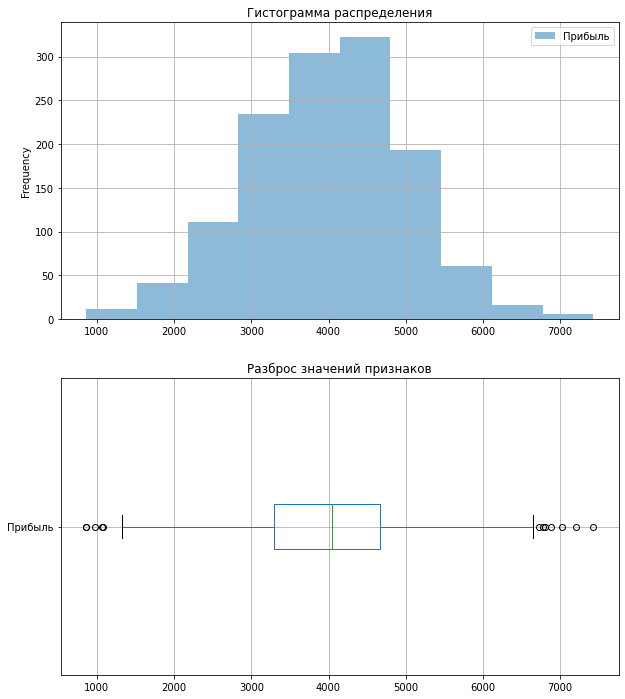

In [36]:
fig, axes = plt.subplots(2, 1, figsize=(10, 12))
money.plot(kind='hist', bins=10, y='Прибыль', grid = True, alpha=0.5, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
money.plot(kind='box', y='Прибыль', ax=axes[1], grid = True, vert=False)
axes[1].set_title('Разброс значений признаков')
plt.show()

Гистограммы показывают нормальное рапределение данных

Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.  В таблице с выручкой для представлена информация за 3 периода, соответственно можно проверить были ли покупки за 3 месяца. 

In [37]:
money['id'].count()

1300

In [38]:
market_money_pivot = pd.pivot_table(market_money, columns='Период', index = 'id', values = 'Выручка')
market_money_pivot.sample(10)


Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215800,5439.5,5036.0,5919.2
215713,4821.0,4872.0,5221.4
215720,5157.5,4727.0,5188.7
215666,4945.0,4138.0,5150.4
215819,4193.0,4869.0,4909.3
215358,3488.0,4727.0,4209.5
216258,5286.0,5337.0,5371.8
215431,5455.5,4692.0,6184.8
216480,4553.0,4649.0,4599.8


Количесвто клиентов равно количеству в таблице market_file = 1300 строк. Теперь из сводной таблицы удалим клиентов, которые не совершали покупки хотя бы в один за 3 поледних месяцев

In [39]:
clients_3m = market_money_pivot[(market_money_pivot['препредыдущий_месяц'] != 0) & 
                                  (market_money_pivot['предыдущий_месяц'] != 0) & 
                                  (market_money_pivot['текущий_месяц'] != 0)]
clients_3m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 215349 to 216647
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   предыдущий_месяц     1297 non-null   float64
 1   препредыдущий_месяц  1297 non-null   float64
 2   текущий_месяц        1297 non-null   float64
dtypes: float64(3)
memory usage: 40.5 KB


Получается, что только 3 клиента не соотвествуют этому условию, учтем это в дальнейшей работе, но также есть один пробел в строке "текущий_месяц"

<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>

Отлично! Еще одно условие ТЗ выполнено 👍

 ## Объединение таблиц

Объединим таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании не понадобятся. 

In [40]:
clients_3m.columns =  ['Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц']
clients_3m.sample(5)

,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц
id,,,
216529,4340.0,4974.0,5019.9
215792,5391.0,5012.0,5192.1
216101,4093.0,4961.0,4975.7
215965,5326.5,5103.0,5650.2
216599,4408.5,4428.0,4521.6


In [41]:
market_time_pivot = market_time.pivot_table(index='id',columns='Период',values='минут')
market_time_pivot.columns = ['Минут_предыдущий_месяц', 'Минут_текущий_месяц']
market_time_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Минут_предыдущий_месяц  1300 non-null   int64
 1   Минут_текущий_месяц     1300 non-null   int64
dtypes: int64(2)
memory usage: 30.5 KB


<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>

И здесь шикарно, хотя можно было обычным `pivot`-ом ограничиться)

In [42]:
data = pd.merge(market_file, clients_3m, how='inner', on='id')
data = pd.merge(data, market_time_pivot, how='inner', on='id').dropna()
display(data.sample(3))
data.info()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц
119,215470,Снизилась,стандарт,да,3.9,4,249,0.93,Кухонная посуда,2,6,4,2,5157.0,4764.0,5623.7,13,11
750,216101,Прежний уровень,стандарт,нет,5.4,5,165,0.11,Техника для красоты и здоровья,3,5,3,11,4093.0,4961.0,4975.7,15,11
528,215879,Прежний уровень,стандарт,нет,5.3,4,476,0.30,Техника для красоты и здоровья,2,0,7,8,6499.0,5596.0,5846.4,22,13


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская активность            1297 non-null   object 
 2   Тип сервиса                          1297 non-null   object 
 3   Разрешить сообщать                   1297 non-null   object 
 4   Маркет_актив_6_мес                   1297 non-null   float64
 5   Маркет_актив_тек_мес                 1297 non-null   int64  
 6   Длительность                         1297 non-null   int64  
 7   Акционные_покупки                    1297 non-null   float64
 8   Популярная_категория                 1297 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  Ошибка_сервиса                

В результате объединения получилось 1297 пользователей активных 3 последних месяца.

## Корреляционный анализ

Построем матрицу корреляции для всего датасета. 

In [43]:
data.phik_matrix() 

interval columns not set, guessing: ['id', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц', 'Минут_предыдущий_месяц', 'Минут_текущий_месяц']


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц
id,1.000000,0.984523,0.115160,0.004809,0.469873,0.000000,0.024118,0.410968,0.169316,0.354388,0.419768,0.201949,0.608039,0.237053,0.417827,0.159800,0.564727,0.471939
Покупательская активность,0.984523,1.000000,0.132247,0.000000,0.546370,0.000000,0.099820,0.506991,0.298036,0.539221,0.504870,0.223697,0.748769,0.223652,0.493370,0.193296,0.685078,0.575662
Тип сервиса,0.115160,0.132247,1.000000,0.286278,0.094182,0.044796,0.404746,0.033339,0.066285,0.186635,0.140387,0.076182,0.100832,0.000000,0.064912,0.123721,0.131084,0.000000
Разрешить сообщать,0.004809,0.000000,0.286278,1.000000,0.000000,0.051971,0.253618,0.017252,0.071769,0.069322,0.204526,0.020464,0.041128,0.069182,0.000000,0.079581,0.042350,0.000000
Маркет_актив_6_мес,0.469873,0.546370,0.094182,0.000000,1.000000,0.080454,0.000000,0.278729,0.149812,0.205783,0.274197,0.147270,0.394108,0.153128,0.313338,0.000000,0.363780,0.328385
Маркет_актив_тек_мес,0.000000,0.000000,0.044796,0.051971,0.080454,1.000000,0.177132,0.000000,0.136175,0.246726,0.140581,0.116310,0.000000,0.061530,0.000000,0.000000,0.106879,0.062485
Длительность,0.024118,0.099820,0.404746,0.253618,0.000000,0.177132,1.000000,0.000000,0.000000,0.190417,0.145909,0.188244,0.120363,0.130041,0.099332,0.143251,0.044660,0.107206
Акционные_покупки,0.410968,0.506991,0.033339,0.017252,0.278729,0.000000,0.000000,1.000000,0.122840,0.199417,0.240499,0.000000,0.310741,0.069144,0.224668,0.063544,0.262189,0.250014
Популярная_категория,0.169316,0.298036,0.066285,0.071769,0.149812,0.136175,0.000000,0.122840,1.000000,0.225622,0.251523,0.000000,0.160623,0.249578,0.047188,0.239610,0.195219,0.089923
Средний_просмотр_категорий_за_визит,0.354388,0.539221,0.186635,0.069322,0.205783,0.246726,0.190417,0.199417,0.225622,1.000000,0.322170,0.069908,0.262610,0.098538,0.176040,0.087571,0.159393,0.182708


<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>

Оставлю ссылку на [материал](https://github.com/hukenovs/coursera_ml_da_specialization/blob/master/C4_Stats_for_data_analysis/Lectures/3-2.Korrelyacii.pdf) про корреляции, может тебе будет интересно)

<AxesSubplot:>

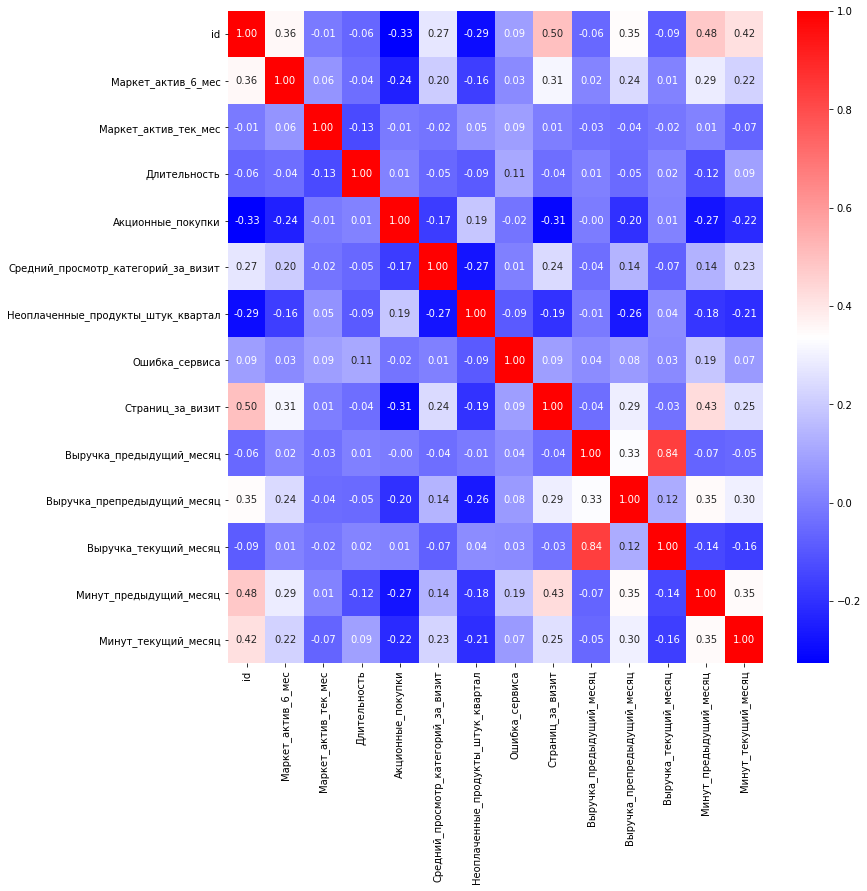

In [44]:
fig, ax = plt.subplots(figsize=(12,12))  
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='bwr') 

<div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️ <a class="tocSkip"> </h2>

Для анализа корреляций полезно строить диаграммы рассеивания. По ним можно обнаружить нелинейные зависимости, которые мы коэффициентами корреляции Пирсона не выявим. Также они позволяют обнаружить выбросы - точки, которые сильно занижают коэффициенты корреляции - тоже важноезамечание для анализа

In [45]:
col_names = ['Акционные_покупки',
             'Длительность',
             'Выручка_предыдущий_месяц',
             'Выручка_препредыдущий_месяц',
             'Выручка_текущий_месяц']

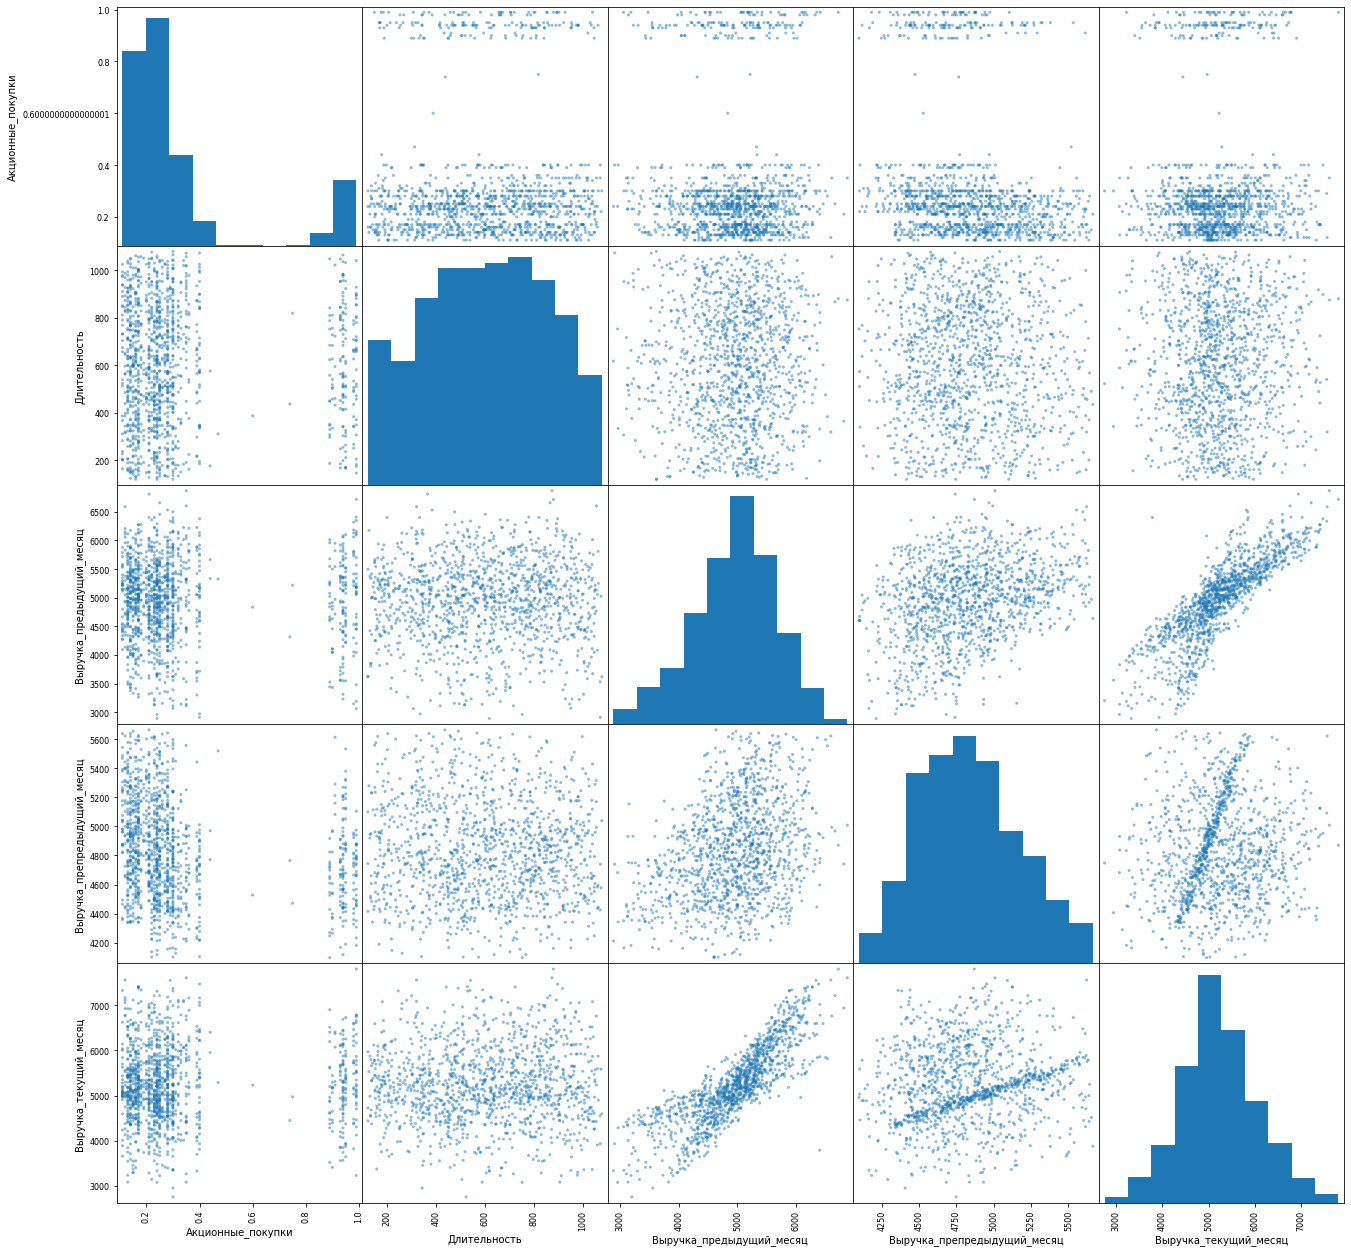

In [46]:
pd.plotting.scatter_matrix(data[col_names], figsize=(22,22)) 
plt.show()

Из полученных данных можно сделать вывод, мультиколлинеарность отсутствует. Наибольший коэф корреляции между количеством просмотренных страниц и времени, проведенном на сайте (Минут_предыдущий_месяц) 

<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>

Можно еще проанализировать баланс целевого признака - если баланс сильно нарушен, можно попробовать поработать с дисбалансом. Можно случайно удалить или добавить N примеров одного из классов - это самая простая и примитивная стратегия, понятная и несложная в реализации. Однако такой подход зачастую бывает не совсем эффективным. Предпочтительно сделать стратегию балансировки классов более управляемой, то есть выполняемой в соответствии с некоторыми правилами. Вот отличная [статья](https://loginom.ru/blog/imbalance-class?ysclid=lahalfdpji666704250) на эту тему.
    
P.S. если работать с балансировкой, то нужно учитывать, что ниже у нас присутствует кроссвалидация. Т.е нельзя делать, например ресэмплинг на всей выборке и использовать ее в кроссвалидации, ведь в таком случае мы получим утечку данных. [Вот](https://datascience.xyz/practice/kak-delat-kross-validaciju-pri-apsemplinge-dannyh.html) полезная статья на эту тему.

## Использование пайплайнов

Применим все изученные модели. Для этого будем использовать пайплайны.

### Пайплайн с использованием ColumnTransformer. 

Количественные и категориальные данные обработать в пайплайне раздельно.

In [47]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

Закодируем целевой показатель

In [48]:
data['Покупательская активность'] = data['Покупательская активность'].apply(lambda x: 1 if x == 'Прежний уровень' else 0)

<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>

Отдельный плюс за лямбду-функцию 💪

In [49]:
X = data.drop(['Покупательская активность', 'id'], axis=1)
y= data['Покупательская активность']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data['Покупательская активность'])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((972, 16), (325, 16), (972,), (325,))

<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>

Круто, что ты фиксируешь `random_state`. Кстати, его можно задать один раз в начале проекта, например, используя любимый нами [numpy](https://stackoverflow.com/questions/21494489/what-does-numpy-random-seed0-do)

Cоздаём списки с названиями признаков

In [51]:
data.sample(10)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц
574,215925,0,стандарт,нет,4.9,4,450,0.27,Мелкая бытовая техника и электроника,2,2,4,13,4458.0,5028.0,4094.0,23,12
900,216251,1,стандарт,да,4.0,4,320,0.24,Мелкая бытовая техника и электроника,5,4,3,8,4565.5,4645.0,4626.6,10,9
84,215435,0,премиум,да,4.8,4,875,0.35,Товары для детей,2,2,5,9,6869.5,5008.0,7605.3,7,11
697,216048,1,стандарт,да,5.2,5,153,0.14,Техника для красоты и здоровья,6,3,3,9,5544.0,5574.0,5700.0,15,20
348,215699,0,стандарт,нет,4.1,3,811,0.93,Косметика и аксесуары,4,1,5,8,4441.5,4518.0,4194.5,12,14
988,216339,1,стандарт,нет,5.8,4,148,0.30,Косметика и аксесуары,3,2,8,3,5608.0,5557.0,5782.2,18,11
991,216342,1,стандарт,нет,4.6,3,610,0.16,Косметика и аксесуары,3,0,3,19,4906.0,5155.0,4820.2,14,16
1269,216620,1,стандарт,да,6.1,4,1001,0.17,Товары для детей,3,5,6,19,5486.0,5396.0,5538.0,17,20
457,215808,0,стандарт,да,4.0,4,417,0.25,Товары для детей,5,5,5,11,3327.0,4353.0,4346.2,17,5
106,215457,0,премиум,нет,4.6,5,764,0.32,Товары для детей,2,5,6,4,5291.5,4387.0,5805.0,8,10


In [52]:
ohe_columns = ['Тип сервиса', 'Разрешить сообщать']
ord_columns = ['Популярная_категория']
num_columns = ['Маркет_актив_6_мес', 
                'Маркет_актив_тек_мес', 
                'Длительность',
                'Акционные_покупки',
                'Средний_просмотр_категорий_за_визит',
                'Неоплаченные_продукты_штук_квартал', 
                'Ошибка_сервиса',
                'Страниц_за_визит']

Создаём пайплайн для подготовки признаков из списка ohe_columns

In [53]:
ohe_pipe = Pipeline([('simpleImputer_after_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('ohe', OneHotEncoder(drop='first', sparse=False))])

 Создаём пайплайн для подготовки признаков из списка ord_columns

In [54]:
ord_pipe = Pipeline(
    [('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[['Товары для детей', 
                             'Домашний текстиль', 
                             'Косметика и аксесуары', 
                             'Техника для красоты и здоровья', 
                             'Кухонная посуда',
                             'Мелкая бытовая техника и электроника']], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        )
    ]
)

<div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️ <a class="tocSkip"> </h2>

Нужно было категории обернуть в еще одни квадратные скобки)

Cоздаём общий пайплайн для подготовки данных

In [55]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Cоздаём итоговый пайплайн: подготовка данных и модель

In [56]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [57]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequ...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  ['Популярная_категория']),
                                                 ('num', MinMaxScaler(),
                                                  ['Маркет_актив_6_мес',
                                                   'Маркет_актив_тек_мес',
                                                   'Длительность',
                                                   'Акционные_покупки',
                                                   'Средний_просмотр_категорий_за_визит',
                                                   'Неоплаченные_продукты_штук_квартал',
                                                   'Ошибка_сервиса',
                                                   'Страниц_за_визит'])])),
                ('models', DecisionTreeClassifier(random_state=42))])

### Создаем пайплайн для поиска лучшей модели из изученных: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), SVC().

Создаем словарь с гиперпараметрами модели

In [58]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
     # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    # словарь для модели SVC()
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
] 

<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>

А так, пайплайн реализован правильно, здорово, что и модел ты в нем реализовал)

Необходимо посмотреть на распределение целевого признака и оценить имеется ли в нем и в зависимости от этого выбрать подходящую метрику. Ощутимым дисбалансом можно назвать все что расходится сильнее чем 25/75

In [59]:
data['Покупательская активность'].value_counts(normalize=True)

1    0.61835
0    0.38165
Name: Покупательская активность, dtype: float64

 Классы целевого признка ближе к сбалансированным. Для определения лучшей модели выбираем метрику ROC-AUC

In [60]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_after_ord',
                                                       

Для оценки лучшей модели использовали метрику ROC-AUC поскольку она не чувствительна к дисбалансу классов и учитывает все возможные пороги классификации. Она показала, что стоит использовать метод опрных векторов со стандартным коэффициентом регуларности С=4.

<div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️ <a class="tocSkip"> </h2>

Вывод FutureWarning я бы убрал, попробуй погуглить как, если не найдешь, подскажу сам 

In [61]:
# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.823102230781576


Качество модели получилось достаточно высоким - модель ощибоется лишь в 9% на тренировочной выборки и в 18% на тестовой.

<div class="alert alert-danger">
<h2> Комментарий ревьюера ❌ <a class="tocSkip"> </h2>

Блоки ниже нужно доработать, надеюсь, сейчас блоков не будет)

## Анализ важности признаков

Цель отбора признаков — найти те, которые вносят наибольший вклад в корректное предсказание.  Оценим важность признаков для лучшей модели и построим график важности с помочью метода SHAP

In [62]:
# В best_model будет храниться наш пайплайн
best_model = randomized_search.best_estimator_
model = best_model.named_steps['models']
model

LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear')

In [63]:
X_train = best_model.named_steps['preprocessor'].fit_transform(X_train)
X_test = best_model.named_steps['preprocessor'].transform(X_test)
explainer = shap.Explainer(model.predict_proba, X_train)
shap_values = explainer(X_test)

PermutationExplainer explainer: 326it [00:52,  5.18it/s]                         


In [64]:
features_out = best_model.named_steps['preprocessor'].get_feature_names_out().tolist()
features_out

['ohe__Тип сервиса_стандарт',
 'ohe__Разрешить сообщать_нет',
 'ord__Популярная_категория',
 'num__Маркет_актив_6_мес',
 'num__Маркет_актив_тек_мес',
 'num__Длительность',
 'num__Акционные_покупки',
 'num__Средний_просмотр_категорий_за_визит',
 'num__Неоплаченные_продукты_штук_квартал',
 'num__Ошибка_сервиса',
 'num__Страниц_за_визит',
 'remainder__Выручка_предыдущий_месяц',
 'remainder__Выручка_препредыдущий_месяц',
 'remainder__Выручка_текущий_месяц',
 'remainder__Минут_предыдущий_месяц',
 'remainder__Минут_текущий_месяц']

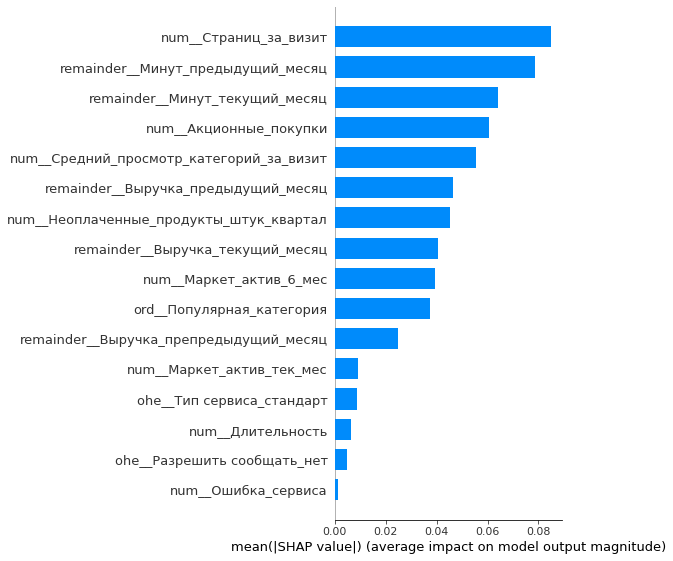

In [65]:
shap.summary_plot(shap_values[:, :, 1], X_test, plot_type="bar", feature_names=features_out)

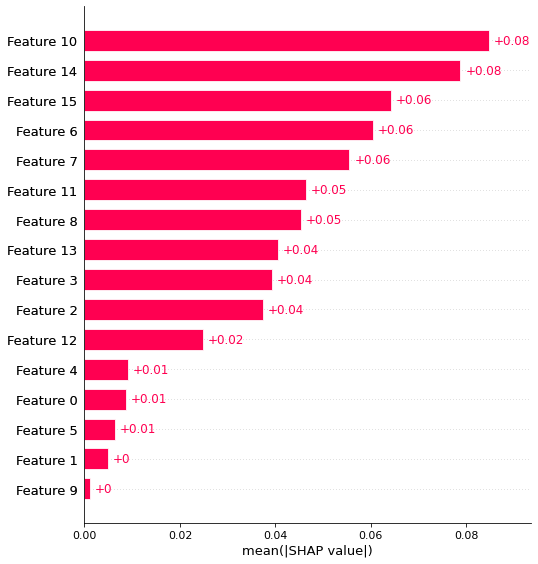

In [66]:
shap.plots.bar(shap_values[:, :, 1], max_display=17) 

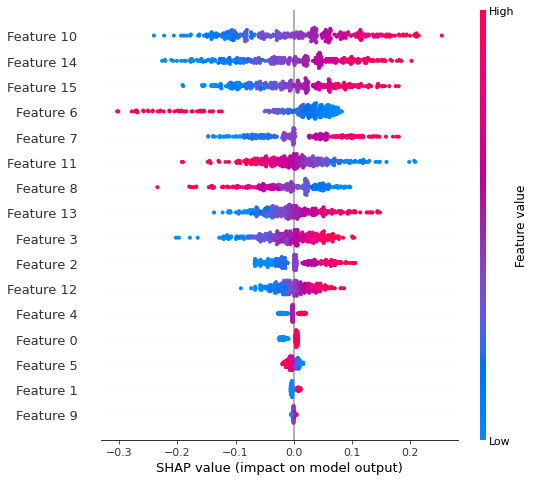

In [67]:
shap.plots.beeswarm(shap_values[:, :, 1], max_display=17) 

<AxesSubplot:ylabel='Feature'>

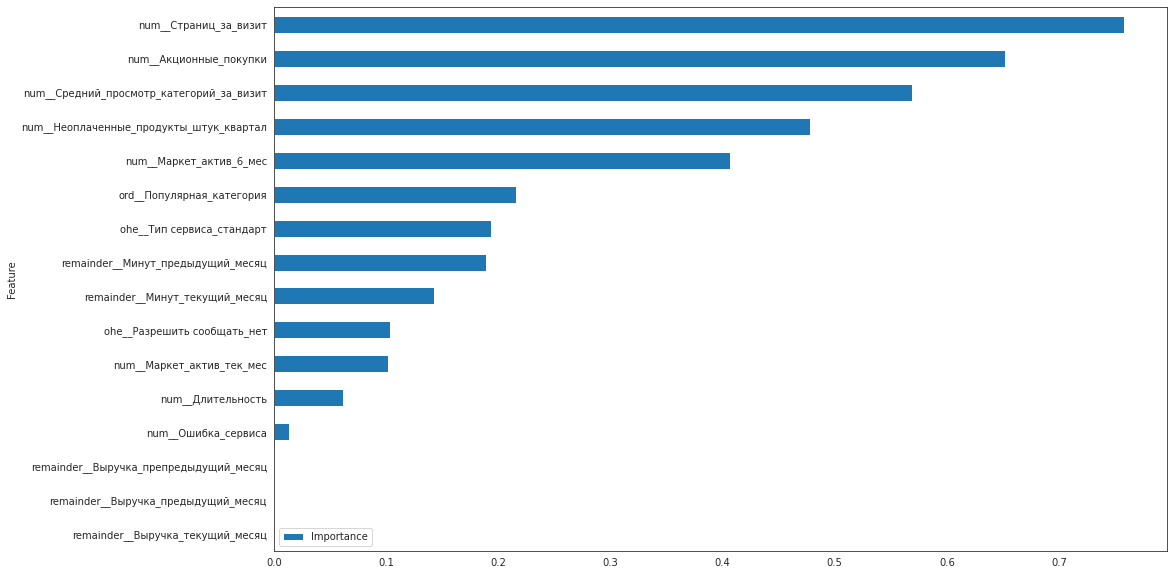

In [68]:
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': features_out, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(16, 10))

В обоих подходах признаками, которые вносят наиболее вклад в корректное предсказание являютяся: Страниц_за_визит, Минут_предыдущий_месяц,  Минут_текущий_мес, Акционные_покупки, Средний_просмотр_категорий_за_визит.

Попробуем исключить те, признаки, которые согласно метода SHAP наименее важные: Ошибка_сервиса, Разрешить сообщать, Длительность, Тип сервиса.

<div class="alert alert-success">
<h2> Комментарий ревьюера v2 ✔️ <a class="tocSkip"> </h2>

Интересный тест 👍 feature selection большая и интересная тема...

In [69]:
X_ = data.drop(['Покупательская активность', 'id','Ошибка_сервиса', 'Разрешить сообщать', 'Длительность', 'Тип сервиса'], axis=1)
y_= data['Покупательская активность']

In [70]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(
    X_,
    y_,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data['Покупательская активность'])

X_train_.shape, X_test_.shape, y_train_.shape, y_test_.shape

((972, 12), (325, 12), (972,), (325,))

In [71]:
num_columns_ = ['Маркет_актив_6_мес', 
                'Маркет_актив_тек_мес', 
                'Акционные_покупки',
                'Средний_просмотр_категорий_за_визит',
                'Неоплаченные_продукты_штук_квартал', 
                'Страниц_за_визит']

In [72]:
data_preprocessor_ = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns_)
    ], 
    remainder='passthrough'
)

In [73]:
pipe_final_ = Pipeline([
    ('preprocessor', data_preprocessor_),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [74]:
pipe_final_.fit(X_train_, y_train_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['Товары '
                                                                                               'для '
                                                                                               'детей',
                                                                                               'Домашний '
                                                                                               'текстиль',
                                                                                               'Косметика '
                                                                                               'и '
                                                                                               'аксесуары',
                                                                                               'Техника '
                                                                                               'для '
                                                                                               'красоты '
                                                                                               'и '
                                                                                               'здоровья',
                                                                                               'Кухонная '
                                                                                               'посуда',
                                                                                               'Мелкая '
                                                                                               'быт...'
                                                                                               'техника '
                                                                                               'и '
                                                                                               'электроника']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  ['Популярная_категория']),
                                                 ('num', MinMaxScaler(),
                                                  ['Маркет_актив_6_мес',
                                                   'Маркет_актив_тек_мес',
                                                   'Акционные_покупки',
                                                   'Средний_просмотр_категорий_за_визит',
                                                   'Неоплаченные_продукты_штук_квартал',
                                                   'Страниц_за_визит'])])),
                ('models', DecisionTreeClassifier(random_state=42))])

In [75]:
randomized_search_ = RandomizedSearchCV(
    pipe_final_, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1)
randomized_search_.fit(X_train_, y_train_)

print('Лучшая модель и её параметры:\n\n', randomized_search_.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['Товары '
                                                                                               'для '
                                                                                               'детей',
                                                                                               'Домашний '
                                                                                               'текстиль',
                

In [76]:
# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred_ = randomized_search_.predict(X_test_)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_, y_test_pred_)}')

Метрика ROC-AUC на тестовой выборке: 0.8255897929706306


Качество модели после удаления незначительных признаков немного увеличилось. Теперь модель ошибается лишь в 8,9% случаях на тренировочной выборке и в 17,4% на тестовой.

## Сегментация покупателей

Выполнии сегментацию покупателей. Для этого будем использовать результаты моделирования и данные о прибыльности покупателей - money.csv.

Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

Выберим группу покупателей c наибольшими затратами за 3 мес. (Прибыль более 4678 - 4й квантиль)

In [77]:
#money_4q = money.loc[money['Прибыль']>4670]
q4 = money['Прибыль'].quantile(.75)
money_q4 =money[(money['Прибыль'] > q4)]
money_q4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 3 to 1296
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       324 non-null    int64  
 1   Прибыль  324 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 7.6 KB


In [78]:
data['Покупательская активность'].unique()

array([0, 1])

<div class="alert alert-warning">
<h2> Комментарий ревьюера v2 ⚠️ <a class="tocSkip"> </h2>

Почему бы тогда не прописывать через 4й квартиль?

In [79]:
data_income = pd.merge(data, money_q4, how='inner', on='id')
data_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323 entries, 0 to 322
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   323 non-null    int64  
 1   Покупательская активность            323 non-null    int64  
 2   Тип сервиса                          323 non-null    object 
 3   Разрешить сообщать                   323 non-null    object 
 4   Маркет_актив_6_мес                   323 non-null    float64
 5   Маркет_актив_тек_мес                 323 non-null    int64  
 6   Длительность                         323 non-null    int64  
 7   Акционные_покупки                    323 non-null    float64
 8   Популярная_категория                 323 non-null    object 
 9   Средний_просмотр_категорий_за_визит  323 non-null    int64  
 10  Неоплаченные_продукты_штук_квартал   323 non-null    int64  
 11  Ошибка_сервиса                  

<div class="alert alert-danger">
<h2> Комментарий ревьюера v2 ❌ <a class="tocSkip"> </h2>

Да, эти графики не очень информативные, попробуй посмотреть на распределение категориальных признаков относительно таргета...
    
Плюс я бы по выбору сегмента добавил бы еще какое-нибудь условие, например, как предложено в задание, вероятность снижения покупательской активности...
    
Основная цель этого блока - дать бизнесу какие-то инсайды относительно выбранной группы и дать рекомендации, как повысить их покупательскую активность

In [80]:
data_income['Покупательская активность'].unique()

array([0, 1])

Покупательская активность у сегмента клиентов с высоки доходам снизилась. Причем у всех 323 без исключения.  Получается таргет исчез 🤷🏻‍♀️

In [81]:
probabilities_valid = randomized_search_.predict_proba(data_income)
data_income['Вероятность'] = probabilities_valid[:,1]
data_income.sample(10)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц,Прибыль,Вероятность
242,216359,1,стандарт,да,4.9,5,387,0.12,Кухонная посуда,4,1,6,7,5296.5,5442.0,5300.4,15,17,5210.0,0.974721
73,215690,0,стандарт,да,4.8,4,907,0.30,Косметика и аксесуары,2,1,1,6,5005.5,5241.0,4931.4,13,14,5660.0,0.633626
10,215398,0,премиум,да,3.5,5,882,0.22,Мелкая бытовая техника и электроника,3,2,6,3,5530.5,4557.0,5854.2,5,6,4770.0,0.080748
114,215843,0,стандарт,да,5.5,3,930,0.14,Техника для красоты и здоровья,5,1,6,10,5201.5,4579.0,5871.0,14,9,4680.0,0.936569
276,216471,1,премиум,да,3.9,4,1042,0.25,Товары для детей,2,1,6,10,3673.0,4661.0,4659.7,17,17,4920.0,0.903817
203,216226,1,стандарт,нет,3.3,5,346,0.29,Домашний текстиль,6,4,4,15,4901.0,4409.0,5457.4,8,12,4850.0,0.748463
317,216622,1,премиум,да,4.1,3,162,0.16,Товары для детей,4,5,3,8,5327.5,4729.0,5976.2,12,8,5140.0,0.312664
266,216431,1,стандарт,да,3.8,5,275,0.17,Товары для детей,1,5,4,13,4923.0,5143.0,5244.1,18,12,5560.0,0.731132
133,215957,1,стандарт,нет,4.4,4,867,0.28,Косметика и аксесуары,5,0,7,9,5276.5,5314.0,5374.0,16,21,5950.0,0.985046
18,215437,0,премиум,да,2.4,3,602,0.32,Косметика и аксесуары,2,5,3,3,4987.5,4875.0,4834.1,10,6,4850.0,0.014918


<AxesSubplot:xlabel='Прибыль', ylabel='Вероятность'>

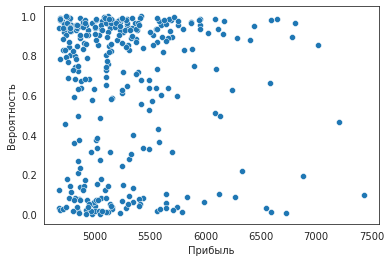

In [82]:
sns.scatterplot(data=data_income, y='Вероятность', x='Прибыль')

Добавим еще критерий - Вероятность ниже 0.5

In [83]:
data_income_prob05 = data_income[data_income['Вероятность']>.5]
display(data_income_prob05.sample(10))
data_income_prob05.info()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минут_предыдущий_месяц,Минут_текущий_месяц,Прибыль,Вероятность
123,215891,1,стандарт,да,4.8,4,795,0.21,Домашний текстиль,4,5,7,16,4477.0,5086.0,4079.2,15,19,4980.0,0.963006
270,216448,1,премиум,да,3.3,4,964,0.14,Домашний текстиль,4,3,8,6,5679.5,5315.0,6125.4,12,13,5740.0,0.595059
302,216573,1,стандарт,нет,4.6,3,324,0.13,Товары для детей,6,1,4,6,6115.0,5386.0,5613.2,20,23,5090.0,0.986871
104,215811,0,премиум,да,3.2,5,786,0.25,Косметика и аксесуары,4,0,8,14,4553.0,5210.0,4113.6,23,21,5120.0,0.996374
114,215843,0,стандарт,да,5.5,3,930,0.14,Техника для красоты и здоровья,5,1,6,10,5201.5,4579.0,5871.0,14,9,4680.0,0.936569
171,216104,1,стандарт,нет,4.1,4,629,0.13,Домашний текстиль,3,0,6,14,4626.5,5375.0,4107.8,14,17,5100.0,0.961754
294,216554,1,премиум,да,5.1,4,893,0.12,Кухонная посуда,2,4,4,9,6205.5,5307.0,7114.2,17,11,5660.0,0.889398
134,215959,1,стандарт,да,3.6,3,825,0.20,Домашний текстиль,5,1,4,10,5346.5,5021.0,5758.6,13,11,5880.0,0.830337
216,216276,1,премиум,да,6.3,5,925,0.13,Техника для красоты и здоровья,5,3,3,11,4773.0,4897.0,5010.9,8,16,5750.0,0.952455
159,216044,1,стандарт,да,5.5,4,347,0.13,Мелкая бытовая техника и электроника,3,5,6,5,4885.0,4945.0,4963.0,16,13,4800.0,0.822191


<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 1 to 322
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   219 non-null    int64  
 1   Покупательская активность            219 non-null    int64  
 2   Тип сервиса                          219 non-null    object 
 3   Разрешить сообщать                   219 non-null    object 
 4   Маркет_актив_6_мес                   219 non-null    float64
 5   Маркет_актив_тек_мес                 219 non-null    int64  
 6   Длительность                         219 non-null    int64  
 7   Акционные_покупки                    219 non-null    float64
 8   Популярная_категория                 219 non-null    object 
 9   Средний_просмотр_категорий_за_визит  219 non-null    int64  
 10  Неоплаченные_продукты_штук_квартал   219 non-null    int64  
 11  Ошибка_сервиса                  

Далее для отобранных покупателей оценим:

1 - Распределение прибыли по популярным категориям 

2 - Распределение прибыли по популярным категориям за текущий, предыдущий и препредыдущий месяц

3 - Посчитать разность между текущим и предыдущими месяцами, предыдущим и препредыдущим месяцем и построить по ним распределение прибыли по категориям. Таким образом мы сможем определить наиболее просевшие категории (у которых будет наибольшая отрицательная разность) и дать соответствующие рекомендации.

In [84]:
data_income_prob05_cat=pd.pivot_table(data_income_prob05, index = 'Популярная_категория', values = 'Прибыль', aggfunc="sum").sort_values(by='Прибыль', ascending=False)
data_income_prob05_cat

,Прибыль
Популярная_категория,
Товары для детей,254330.0
Домашний текстиль,231310.0
Косметика и аксесуары,208640.0
Мелкая бытовая техника и электроника,198590.0
Техника для красоты и здоровья,157800.0
Кухонная посуда,100470.0


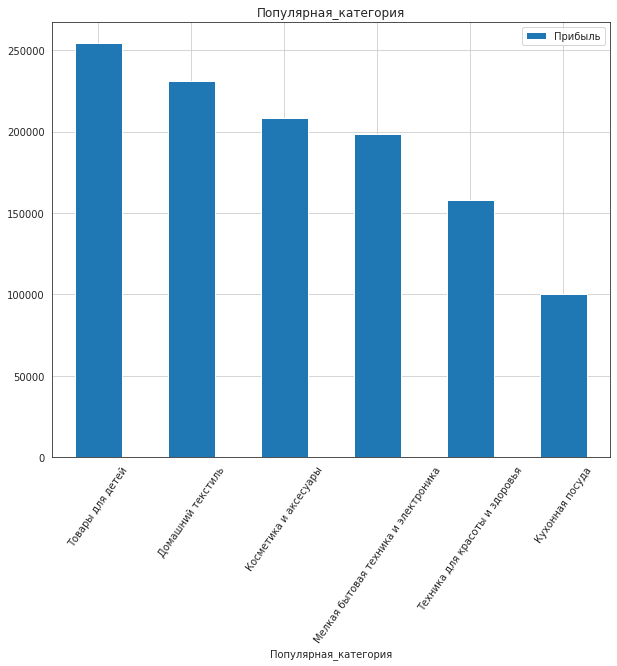

In [85]:
data_income_prob05_cat.plot.bar(rot=55, grid=True, figsize=(10,8), title="Популярная_категория")
plt.show()

<div class="alert alert-warning">
<h2> Комментарий ревьюера v2 ⚠️ <a class="tocSkip"> </h2>

Да, уже лучше, но я бы еще на распределение категориальных признаков посмотрел...

In [86]:
data_income_prob05_period=pd.pivot_table(data_income_prob05, index = 'Популярная_категория', 
                                         values = ['Выручка_препредыдущий_месяц', 'Выручка_предыдущий_месяц', 'Выручка_текущий_месяц'], 
                                         aggfunc="sum")[['Выручка_препредыдущий_месяц', 'Выручка_предыдущий_месяц', 'Выручка_текущий_месяц']]
data_income_prob05_period

,Выручка_препредыдущий_месяц,Выручка_предыдущий_месяц,Выручка_текущий_месяц
Популярная_категория,,,
Домашний текстиль,219786.0,221455.0,229217.3
Косметика и аксесуары,198441.0,199678.0,207232.3
Кухонная посуда,96138.0,95824.5,98247.7
Мелкая бытовая техника и электроника,189075.0,192239.5,198619.9
Техника для красоты и здоровья,146760.0,141570.0,149325.8
Товары для детей,237280.0,226743.5,238460.4


In [87]:
data_income_prob05_period['Δ_пред_предпред_месяц']=data_income_prob05_period['Выручка_предыдущий_месяц']-data_income_prob05_period['Выручка_препредыдущий_месяц']
data_income_prob05_period['Δ_тек_пред_месяц']=data_income_prob05_period['Выручка_текущий_месяц']-data_income_prob05_period['Выручка_предыдущий_месяц']
data_income_prob05_period[['Выручка_препредыдущий_месяц', 'Δ_пред_предпред_месяц', 'Выручка_предыдущий_месяц', 'Δ_тек_пред_месяц', 'Выручка_текущий_месяц']]

,Выручка_препредыдущий_месяц,Δ_пред_предпред_месяц,Выручка_предыдущий_месяц,Δ_тек_пред_месяц,Выручка_текущий_месяц
Популярная_категория,,,,,
Домашний текстиль,219786.0,1669.0,221455.0,7762.3,229217.3
Косметика и аксесуары,198441.0,1237.0,199678.0,7554.3,207232.3
Кухонная посуда,96138.0,-313.5,95824.5,2423.2,98247.7
Мелкая бытовая техника и электроника,189075.0,3164.5,192239.5,6380.4,198619.9
Техника для красоты и здоровья,146760.0,-5190.0,141570.0,7755.8,149325.8
Товары для детей,237280.0,-10536.5,226743.5,11716.9,238460.4


В данной таблице виден по всем категориям прирост прибыли. Только по двум категориям был недобор прибыли в предыдущем месяце - Товары для детей и  Техника для красоты и здоровья, но прибыль текущего периода перекрыла этот недобор. Необходимо оценить какие изменения были за эти периоды по этим 2 категориям товаров. Возможно недостаточность маркетинговых коммуникаций, акций на товары данных категорий.

## Общий вывод

На первом этапе загрузили данные и провели предобработку данных. Пропусков в таблицах нет. Типы данных определны верно. Данные в таблицах соответствуют описанию. Дубликатов а данных не выявлено. 

Далее провели необходимую предобработку данных. Проверили уникальные значения категориальных признаков и превели их к единообразию.

На следующем шаге провели статистический анализ всех признаков и вывели описательные статистики для всех признаков. И сделали следующие выводы о Покупательской активности:

- маркетинговая активность стимулирует  активность покупателей - при большем значении маркетинговых коммуникаций компании (рассылок, звонков, показов рекламы и прочего) за последние полгода покупательская активность чаще сохранялась на прежнем уровне. При маркетинговой активности ниже 3х коммунакаций - покупательская активность снижалась;

- покупательская активность показала зависимость от доли покупок по акции от общего числа покупок за последние 6 месяцев. Выявлена четкая граница - 30%. Если доля акционных покупок составляла ниже 30% покупательская активность значитально снижалась;

- длительноть времени с момента регистрации покупателя на сайте не влияет на покупательную активность

-  чем выше активность на сайте (количество просмотренных категорий и страниц за визит), тем выше покупательская активность;

- до 5 неоплаченных товаров в корзине не влияют на покупательскую активность;

- число сбоев, которые коснулись покупателя во время посещения сайта, не влияет на покупательскую активность. 

При помощий пайплана выявили ниболее подходящую модель - LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear'), которая показала довольно высокий результат на тренировочной и тестовой выборках.

После анализа признаков исключили 4 наименее важных признака - 'Ошибка_сервиса', 'Разрешить сообщать', 'Длительность', 'Тип сервиса', тем самым улучшив качество модели. Теперь модель ошибается лишь в 8,9% случаях на тренировочной выборке и в 17,4% на тестовой.

На этапе сегментации покупателей с учетом наибольшей прибыли и вероятностью снижения покупательской активности оценили, что наибольшие затраты приходят на категорию Товаров для детей   и Домашний текстиль. В рещультате оценки изменения выручки за 3 послених месяца по всем категориям замечен прирост. По 2 категориям Товары для детей и  Техника для красоты и здоровья прирост нестабилен от месяца к месяцу, что требуем детального изчения изменений в коммуникации с покупателями для оценки причин.
